## Setup

In [1]:
import gym
import seaborn as sns
from time import sleep

In [2]:
env = gym.make("CartPole-v1")

In [3]:
n = env.observation_space.shape[0]
a = env.action_space.n

Create samples

In [4]:
num_samples = 10000

Hyperparameters

In [5]:
num_bins = 10
n_episodes = 5000
n_episodes_test = 100
lr = 0.9
max_steps = 100
gamma = 0.99

In [6]:
max_epsilon = 1
min_epsilon = 1e-2
decay_rate = 3e-3

In [7]:
mutate = lambda reward, step: -1 if step != 499 and done else 0

In [8]:
sample_states = np.stack([env.observation_space.sample() for _ in range(num_samples)])

In [9]:
sample_states = np.concatenate([sample_states, np.zeros((num_samples, 2))], axis=1)

In [10]:
for i, s in enumerate(sample_states):
    if s[1] < 0: sample_states[i, -2] = 1
    sample_states[i, 1] = np.log(np.abs(s[1]))
    
    if s[3] < 0: sample_states[i, -1] = 1
    sample_states[i, 3] = np.log(np.abs(s[3]))

/home/vaisakh/anaconda3/envs/lab/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


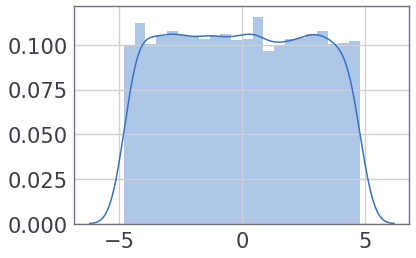

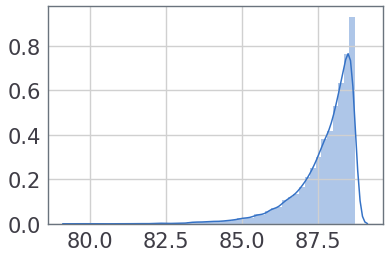

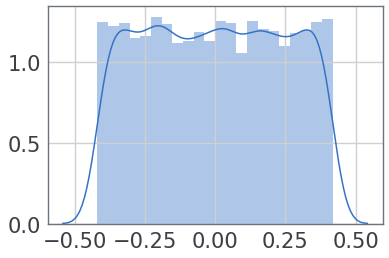

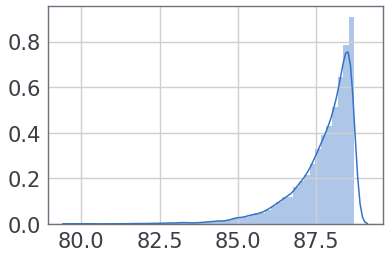

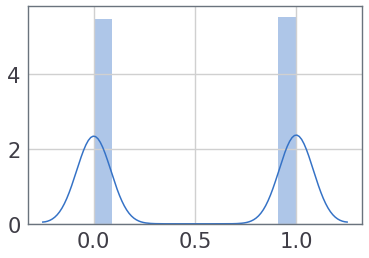

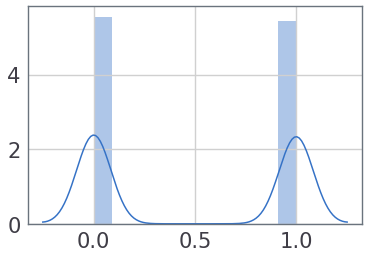

In [11]:
sns.distplot(sample_states[:, 0], hist=True); plt.show()
sns.distplot(sample_states[:, 1], hist=True); plt.show()
sns.distplot(sample_states[:, 2], hist=True); plt.show()
sns.distplot(sample_states[:, 3], hist=True); plt.show()
sns.distplot(sample_states[:, 4], hist=True); plt.show()
sns.distplot(sample_states[:, 5], hist=True); plt.show()

In [12]:
bins = np.zeros((n, num_bins))
for i, _ in enumerate(bins):
    bins[i] = np.linspace(sample_states[:, i].min(), sample_states[:, i].max(), num_bins)

In [13]:
to_decimal = lambda x, base: int((x * (base ** np.arange(len(x)))).sum())

In [14]:
def to_abstract(s):
    if len(s.shape) == 1: return to_abstract(np.expand_dims(s, axis=0)).squeeze(axis=0)
        
    s = np.concatenate([s, np.zeros((len(s), 1))], axis=1)
    neg_ids = s[:, 1] < 0
    s[neg_ids, 4] += 1
    s[neg_ids, 1] = np.log(np.abs(s[neg_ids, 1]))
    neg_ids = s[:, 3] < 0
    s[neg_ids, 4] += 2
    s[neg_ids, 3] = np.log(np.abs(s[neg_ids, 3]))
    
    for i, b in enumerate(bins): s[: , i] = np.digitize(s[: , i], b) - 1

    return np.array([to_decimal(s_i, num_bins) for s_i in s])

In [15]:
n = num_bins ** n * 4

In [16]:
q_table = np.zeros((n, a))

## Train

In [17]:
rewards = []
epsilon = max_epsilon

In [18]:
explore = lambda eps: bool(np.random.binomial(1, eps))

In [19]:
for episode in tqdm(range(n_episodes)):
    state = to_abstract(env.reset())
    done = False
    total_rewards = 0
    
    for step in range(max_steps):
        action = env.action_space.sample() if explore(epsilon) else q_table[state].argmax()

        next_state, actual_reward, done, _ = env.step(action)
        reward = mutate(actual_reward, step)
        next_state = to_abstract(next_state)
        
        # Bellman Equation
        expected_reward = reward + gamma * q_table[next_state].max()
        dq = expected_reward - q_table[state, action]
        q_table[state, action] += lr * dq
        
        total_rewards += actual_reward
        state = next_state
        if done: break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
    rewards.append(total_rewards)

In [20]:
print(f'Score over time: {sum(rewards) / n_episodes:.2f}')
print(np.round(q_table, 2))
print(epsilon)

Score over time: 57.03
[[0. 0.]
 [0. 0.]
 [0. 0.]
 ...
 [0. 0.]
 [0. 0.]
 [0. 0.]]
0.010000303753191348


In [21]:
q_table.sum(axis=1).nonzero()[0]

array([ 9192,  9193,  9194,  9195,  9292,  9293,  9294,  9295,  9392,
        9393,  9394,  9395,  9492,  9493,  9494,  9495,  9592,  9593,
        9594,  9595,  9596, 19193, 19194, 19195, 19196, 19293, 19294,
       19295, 19296, 19393, 19394, 19395, 19396, 19492, 19493, 19494,
       19495, 19496, 19594, 19595, 19596, 29192, 29193, 29194, 29292,
       29293, 29294, 29295, 29392, 29393, 29394, 29492, 29493, 29494,
       29592, 29593, 29594, 39194, 39195, 39294, 39295, 39296, 39394,
       39395, 39396, 39494, 39495, 39496, 39594, 39595, 39596])

In [22]:
print( f'Percentage of Q-Table learned: {len(q_table.sum(axis=1).nonzero()[0]) / n * 100:.2f}%')

Percentage of Q-Table learned: 0.18%


In [23]:
groupmean = lambda x, n: [sum(x[i:i + n]) / n for i in range(0, len(x) - n, n)]

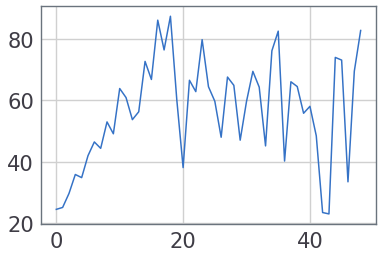

In [24]:
plot(groupmean(rewards, 100))

In [25]:
test_rewards = []
for episode in tqdm(range(n_episodes_test)):
    state = to_abstract(env.reset())
    done = False
    total_rewards = 0
    
    while not done:
        action = q_table[state].argmax()
        
        state, reward, done, _ = env.step(action)
        state = to_abstract(state)
        
        total_rewards += reward

    test_rewards.append(total_rewards)

In [26]:
print(f'Score over time: {sum(test_rewards) / n_episodes_test:.2f}')

Score over time: 116.99


In [30]:
state = to_abstract(env.reset())
total_rewards = 0
done = False
while not done:
    env.render()
    action = q_table[state].argmax()
    if q_table[state].sum() == 0: print('NOT ENCOUNTERED!')
    state, r, done, _ = env.step(action)
    state = to_abstract(state)
    total_rewards += r
    
env.close()
print(total_rewards)

183.0
